## Data Scientist Assessment - Evil Geniuses

#### Data: 
A dataset of Starcraft player performance data in ranked games
#### Goal:
Develop a model to predict a player’s rank and offer guidance and suggestions to the stakeholders


#### EDA

In [30]:
import pandas as pd
import numpy as np
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here
# ...


df = pd.read_csv("D:/MSIA/Intern/Assessment/data/starcraft_player_data.csv")
df.head(5)
df.shape



(3395, 20)

In [2]:
df.describe()
df.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

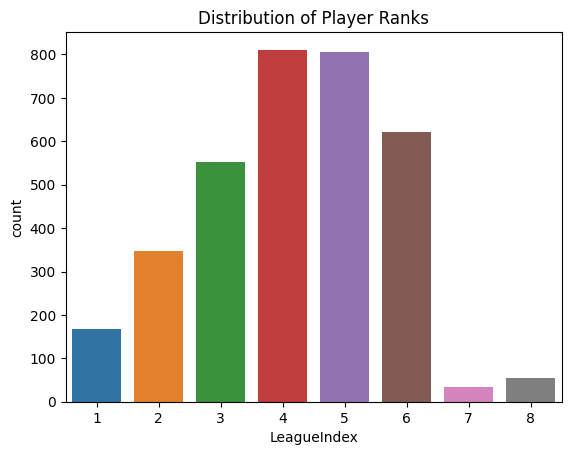

In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of LeagueIndex (Rank)
sns.countplot(x='LeagueIndex', data=df)
plt.title('Distribution of Player Ranks')
plt.show()


In [12]:
# check if there are non-integer or non-float values in the columns.
for variable in df.columns:
    non_numeric_values = df[variable].loc[~pd.to_numeric(df[variable], errors='coerce').notnull()]
    count = len(non_numeric_values)
    if count > 0:
        print(f"Variable '{variable}' contains {count} non-integer or non-float values.")



Variable 'Age' contains 55 non-integer or non-float values.
Variable 'HoursPerWeek' contains 56 non-integer or non-float values.
Variable 'TotalHours' contains 57 non-integer or non-float values.


In [25]:
# the rows where TotalHours is ?
filtered_df = df[df['TotalHours'] == '?']
print(filtered_df)


      GameID  LeagueIndex Age HoursPerWeek TotalHours       APM   
358     1064            5  17           20          ?   94.4724  \
1841    5255            5  18            ?          ?  122.2470   
3340   10001            8   ?            ?          ?  189.7404   
3341   10005            8   ?            ?          ?  287.8128   
3342   10006            8   ?            ?          ?  294.0996   
3343   10015            8   ?            ?          ?  274.2552   
3344   10016            8   ?            ?          ?  274.3404   
3345   10017            8   ?            ?          ?  245.8188   
3346   10018            8   ?            ?          ?  211.0722   
3347   10021            8   ?            ?          ?  189.5778   
3348   10022            8   ?            ?          ?  210.5088   
3349   10023            8   ?            ?          ?  248.0118   
3350   10024            8   ?            ?          ?  299.2290   
3351   10025            8   ?            ?          ?  179.998

In [31]:
# fill in the ? value in the column TotalHours
from sklearn.ensemble import RandomForestRegressor

# Handle missing values
df['TotalHours'] = df['TotalHours'].replace('?', float('nan')).astype(float)

# Split the dataset into train and test sets
train_data = df[df['TotalHours'].notna()]
test_data = df[df['TotalHours'].isna()]

# Prepare the data
features = ['LeagueIndex', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys',
            'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs',
            'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade',
            'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']

X_train = train_data[features]
y_train = train_data['TotalHours']
X_test = test_data[features]

# Create a Random Forest Regressor model
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict missing values
predicted_total_hours = model.predict(X_test)

# Fill in the missing values in the original dataset
df.loc[df['TotalHours'].isna(), 'TotalHours'] = predicted_total_hours

# the rows where HoursPerWeek is ?
filtered_df = df[df['HoursPerWeek'] == '?']
print(filtered_df)


      GameID  LeagueIndex Age HoursPerWeek  TotalHours       APM   
1841    5255            5  18            ?      763.52  122.2470  \
3340   10001            8   ?            ?     1107.34  189.7404   
3341   10005            8   ?            ?    50953.86  287.8128   
3342   10006            8   ?            ?    51400.95  294.0996   
3343   10015            8   ?            ?     1584.46  274.2552   
3344   10016            8   ?            ?     1935.48  274.3404   
3345   10017            8   ?            ?     3109.73  245.8188   
3346   10018            8   ?            ?     1160.74  211.0722   
3347   10021            8   ?            ?     1131.01  189.5778   
3348   10022            8   ?            ?     1292.51  210.5088   
3349   10023            8   ?            ?     3021.28  248.0118   
3350   10024            8   ?            ?    51180.55  299.2290   
3351   10025            8   ?            ?     1299.84  179.9982   
3352   10026            8   ?            ?    51

In [32]:
# fill in the ? value in the column HoursPerWeek
from sklearn.ensemble import RandomForestRegressor

# Handle missing values
df['HoursPerWeek'] = df['HoursPerWeek'].replace('?', float('nan')).astype(float)

# Split the dataset into train and test sets
train_data = df[df['HoursPerWeek'].notna()]
test_data = df[df['HoursPerWeek'].isna()]

# Prepare the data
features = ['LeagueIndex', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys',
            'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs',
            'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade',
            'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed', 'TotalHours']

X_train = train_data[features]
y_train = train_data['HoursPerWeek']
X_test = test_data[features]

# Create a Random Forest Regressor model
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict missing values
predicted_HoursPerWeek = model.predict(X_test)

# Fill in the missing values in the original dataset
df.loc[df['HoursPerWeek'].isna(), 'HoursPerWeek'] = predicted_HoursPerWeek

# the rows where HoursPerWeek is ?
filtered_df = df[df['Age'] == '?']
print(filtered_df)


      GameID  LeagueIndex Age  HoursPerWeek  TotalHours       APM   
3340   10001            8   ?         24.24     1107.34  189.7404  \
3341   10005            8   ?         40.24    50953.86  287.8128   
3342   10006            8   ?         45.24    51400.95  294.0996   
3343   10015            8   ?         36.18     1584.46  274.2552   
3344   10016            8   ?         32.94     1935.48  274.3404   
3345   10017            8   ?         76.98     3109.73  245.8188   
3346   10018            8   ?         29.62     1160.74  211.0722   
3347   10021            8   ?         34.00     1131.01  189.5778   
3348   10022            8   ?         30.54     1292.51  210.5088   
3349   10023            8   ?         33.26     3021.28  248.0118   
3350   10024            8   ?         40.04    51180.55  299.2290   
3351   10025            8   ?         26.10     1299.84  179.9982   
3352   10026            8   ?         31.30    51671.80  340.1982   
3353   10028            8   ?     

In [33]:
# fill in the ? value in the column Age
from sklearn.ensemble import RandomForestRegressor

# Handle missing values
df['Age'] = df['Age'].replace('?', float('nan')).astype(float)

# Split the dataset into train and test sets
train_data = df[df['Age'].notna()]
test_data = df[df['Age'].isna()]

# Prepare the data
features = ['LeagueIndex', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys',
            'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs',
            'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade',
            'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed','TotalHours','HoursPerWeek']

X_train = train_data[features]
y_train = train_data['HoursPerWeek']
X_test = test_data[features]

# Create a Random Forest Regressor model
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict missing values
predicted_Age = model.predict(X_test)

# Fill in the missing values in the original dataset
df.loc[df['Age'].isna(), 'Age'] = predicted_Age

# the rows where LeagueIndex = 8
print(df)


      GameID  LeagueIndex    Age  HoursPerWeek  TotalHours       APM   
0         52            5  27.00         10.00     3000.00  143.7180  \
1         55            5  23.00         10.00     5000.00  129.2322   
2         56            4  30.00         10.00      200.00   69.9612   
3         57            3  19.00         20.00      400.00  107.6016   
4         58            3  32.00         10.00      500.00  122.8908   
...      ...          ...    ...           ...         ...       ...   
3390   10089            8  72.60         70.46     1364.83  259.6296   
3391   10090            8  31.98         33.80    51190.25  314.6700   
3392   10092            8  24.00         25.70    51125.30  299.4282   
3393   10094            8  31.98         32.24     1353.20  375.8664   
3394   10095            8  40.00         39.48    51343.90  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks   
0            0.003515         0.000220              7        0

In [ ]:
# the rows where HoursPerWeek is ?
filtered_dff = df[df['LeagueIndex'] == 8]
print(filtered_dff)

In [34]:
# check if there are non-integer or non-float values in the columns.
for variable in df.columns:
    non_numeric_values = df[variable].loc[~pd.to_numeric(df[variable], errors='coerce').notnull()]
    count = len(non_numeric_values)
    if count > 0:
        print(f"Variable '{variable}' contains {count} non-integer or non-float values.")



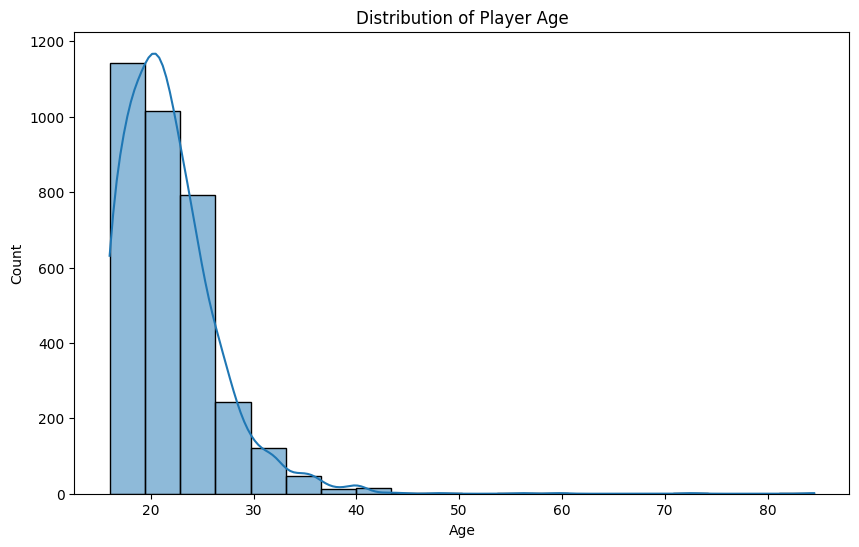

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Distribution of Player Age')
plt.xlabel('Age')
plt.ylabel('Count')
# plt.gca().invert_xaxis()  # Invert the x-axis to display age in ascending order
plt.show()


#### 
the Age is skewed and need normalize before neural network. Let's see if other features also need normalizing before model training.

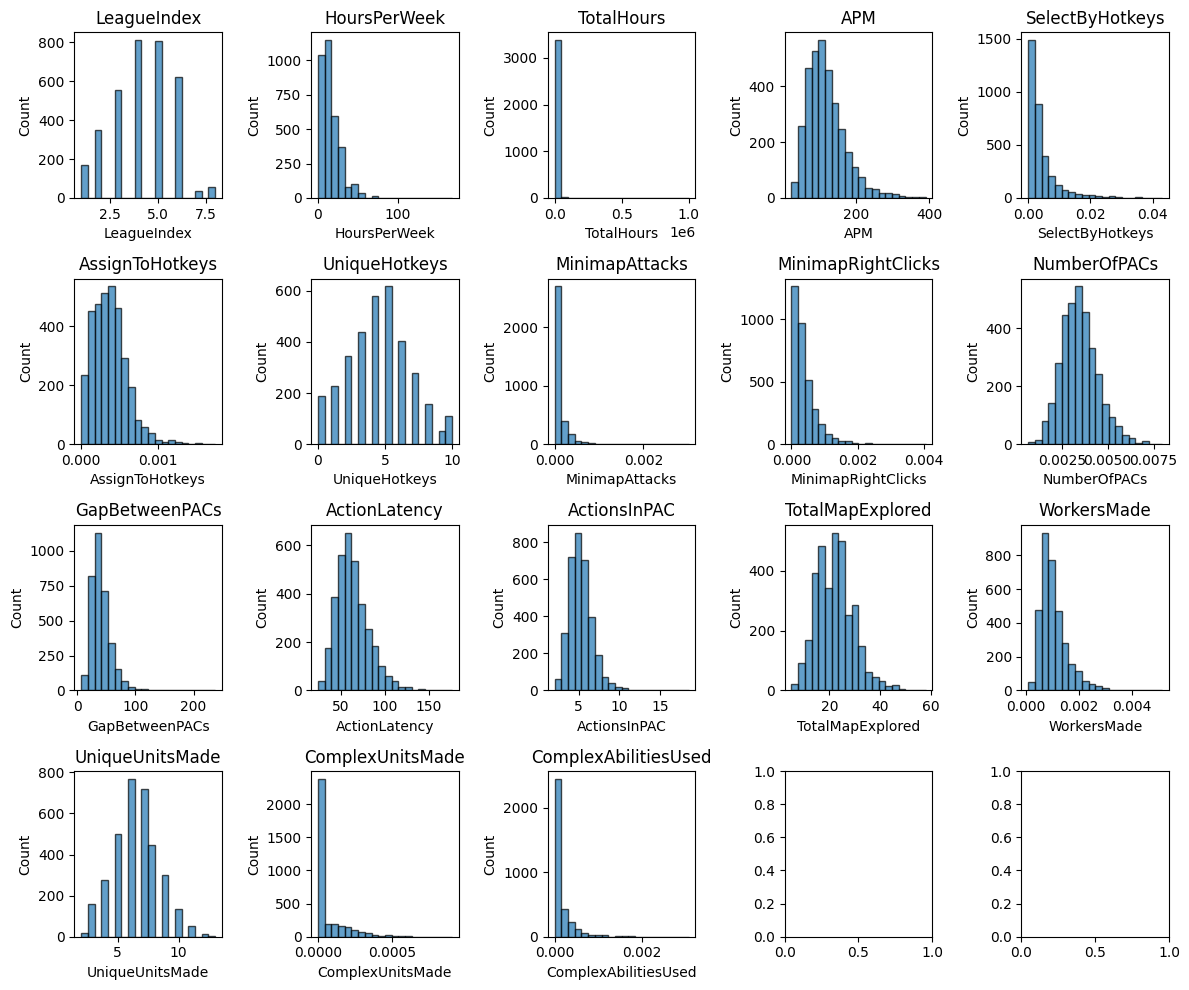

In [38]:

# Define the variables for the histograms
variables = ['LeagueIndex', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys',
             'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks',
             'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC',
             'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
             'ComplexAbilitiesUsed']

# Create a 4x5 grid of histograms
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()

# Iterate over variables and create histograms
for i, variable in enumerate(variables):
    axes[i].hist(df[variable], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Count')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


#### 
From the histogram result, the following features do not need log tranformation: LeagueIndex, UniqueHotkeys, NumberOfPACs, ActionLatency, ActionsInPAC, TotalMapExplored, UniqueUnitsMade.

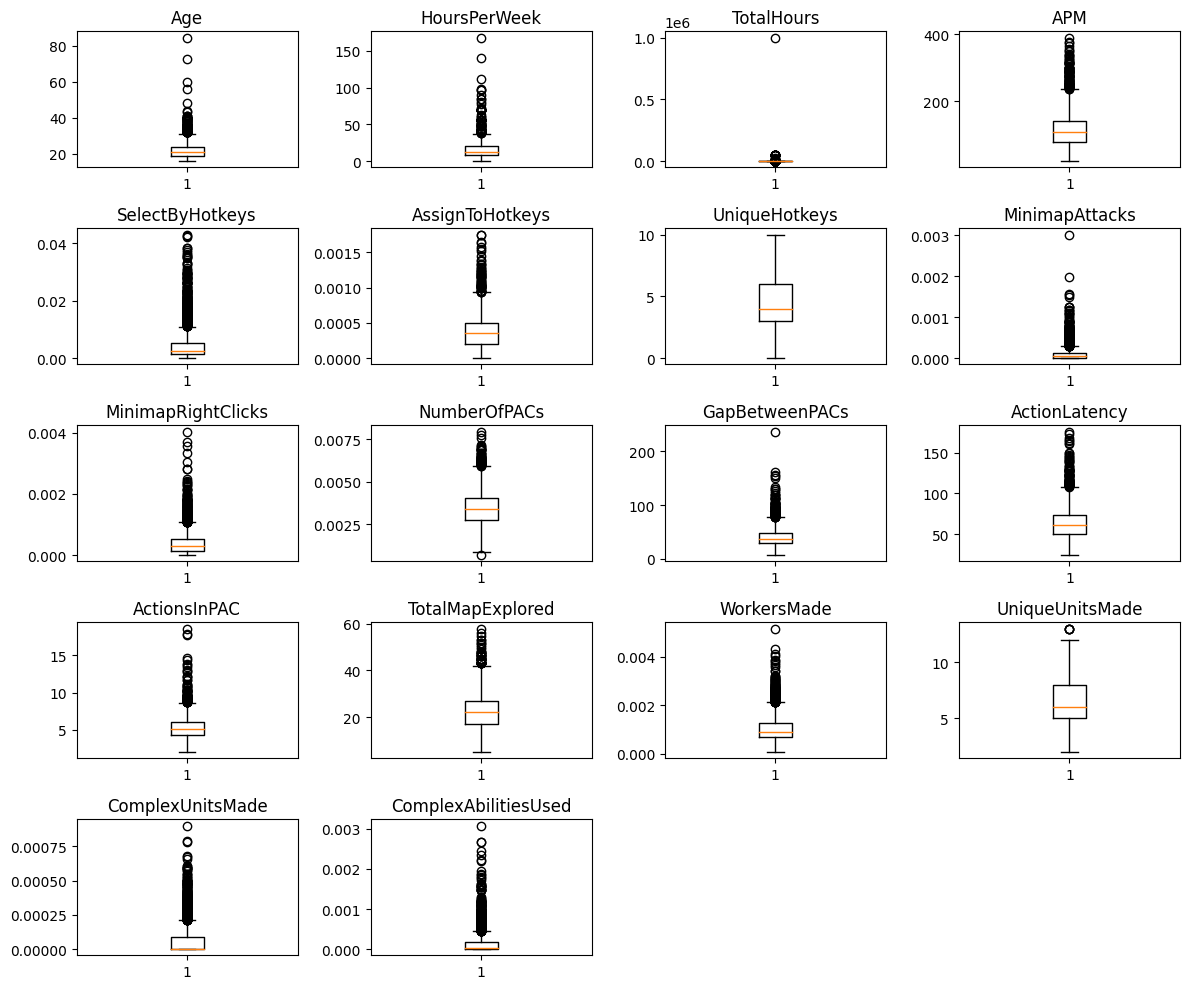

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Select features
features = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
            'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
            'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
            'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']

# Plot box plots for each feature
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features):
    plt.subplot(5, 4, i+1)
    plt.boxplot(df[feature])
    plt.title(feature)
    plt.tight_layout()

plt.show()


In [39]:
df.LeagueIndex.value_counts()

LeagueIndex
4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: count, dtype: int64

#### 
Now the data types are either integer or float.

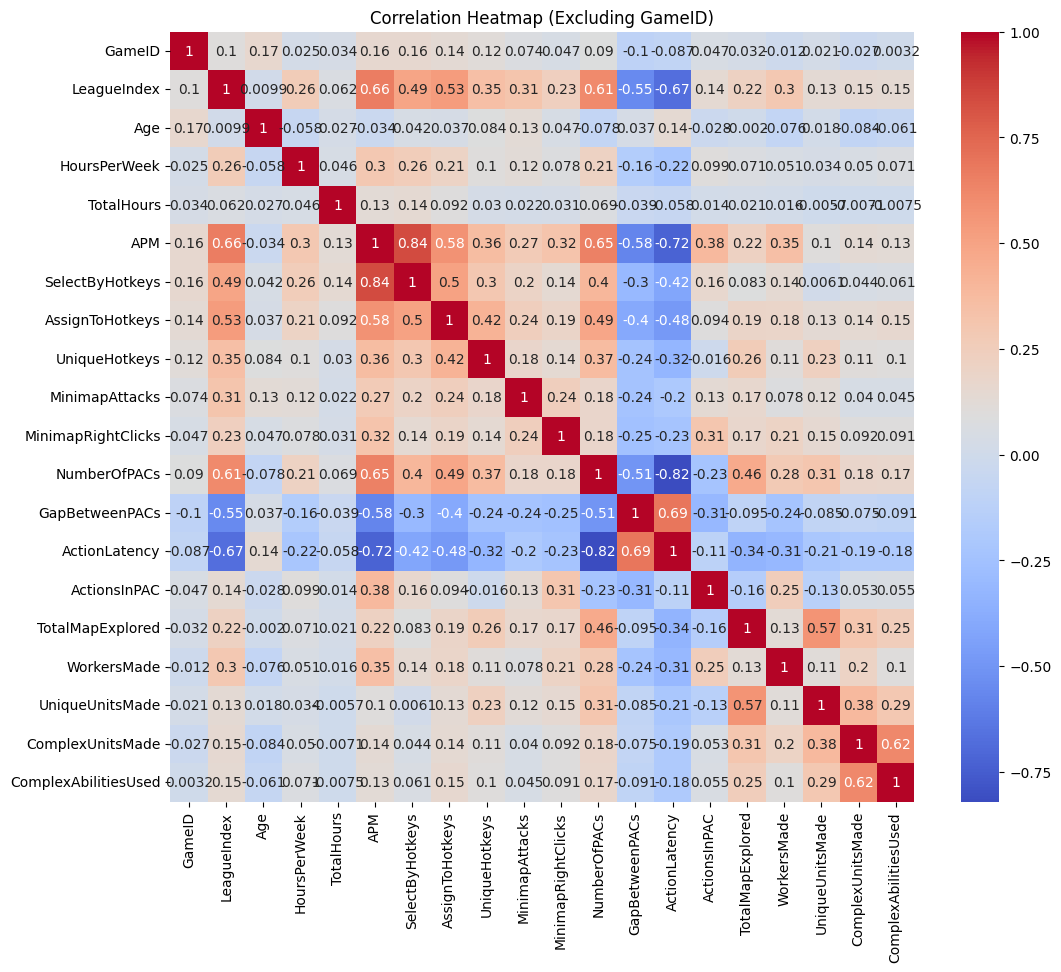

In [43]:

# Compute the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Excluding GameID)')
plt.show()


####
Model

####
Logistic regression

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


# Select features and target variable
features = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
            'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
            'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
            'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']
target = 'LeagueIndex'

# Prepare the data
X = df[features]
y = df[target]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify the skewed variables
skewed_vars = ['HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
               'MinimapAttacks', 'MinimapRightClicks', 'GapBetweenPACs', 'WorkersMade',
               'ComplexUnitsMade', 'ComplexAbilitiesUsed']

# Normalize skewed variables using log transformation
X_train[skewed_vars] = np.log1p(X_train[skewed_vars])
X_test[skewed_vars] = np.log1p(X_test[skewed_vars])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train the logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.38      0.35      0.37        31
           2       0.38      0.26      0.31        80
           3       0.31      0.22      0.26       112
           4       0.35      0.46      0.40       167
           5       0.37      0.39      0.38       158
           6       0.56      0.56      0.56       117
           7       0.00      0.00      0.00         4
           8       0.91      1.00      0.95        10

    accuracy                           0.40       679
   macro avg       0.41      0.41      0.40       679
weighted avg       0.39      0.40      0.39       679



####
Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

# Split the data into features (X) and target variable (y)
X = df.drop('LeagueIndex', axis=1)
y = df['LeagueIndex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:


# Define the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=kfold, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)




Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END ma

In [47]:
# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.35      0.41        31
           2       0.39      0.25      0.31        80
           3       0.31      0.28      0.29       112
           4       0.37      0.47      0.42       167
           5       0.40      0.44      0.42       158
           6       0.57      0.54      0.55       117
           7       0.00      0.00      0.00         4
           8       1.00      1.00      1.00        10

    accuracy                           0.42       679
   macro avg       0.44      0.42      0.42       679
weighted avg       0.42      0.42      0.41       679



In [31]:
# %pip install xgboost

####
Xgboost

In [48]:
df['LeagueIndex'] = df['LeagueIndex'] - 1

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

# Split the data into features (X) and target variable (y)
X = df.drop('LeagueIndex', axis=1)
y = df['LeagueIndex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=kfold, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)




Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END 

In [51]:
# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.35      0.39        31
           1       0.39      0.25      0.31        80
           2       0.31      0.26      0.28       112
           3       0.29      0.33      0.31       167
           4       0.32      0.38      0.35       158
           5       0.52      0.55      0.53       117
           6       0.00      0.00      0.00         4
           7       1.00      1.00      1.00        10

    accuracy                           0.37       679
   macro avg       0.41      0.39      0.40       679
weighted avg       0.37      0.37      0.36       679



##
Neural Network

In [29]:
df['LeagueIndex'] = df['LeagueIndex'] + 1

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# Select features and target variable
features = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
            'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs',
            'GapBetweenPACs', 'ActionLatency', 'ActionsInPAC', 'TotalMapExplored',
            'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade', 'ComplexAbilitiesUsed']
target = 'LeagueIndex'

# Prepare the data
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize skewed variables using log transformation
skewed_vars = ['HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys',
               'MinimapAttacks', 'MinimapRightClicks', 'GapBetweenPACs', 'WorkersMade',
               'ComplexUnitsMade', 'ComplexAbilitiesUsed']
X_train[skewed_vars] = np.log1p(X_train[skewed_vars])
X_test[skewed_vars] = np.log1p(X_test[skewed_vars])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network classifier
mlp = MLPClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
}


In [31]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Best Parameters:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (200,)}
Best Score:  0.41235955056179774


c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.26      0.21      0.23        24
           2       0.39      0.28      0.32        69
           3       0.32      0.32      0.32       102
           4       0.34      0.36      0.35       151
           5       0.35      0.42      0.38       157
           6       0.61      0.57      0.59       161
           7       0.00      0.00      0.00         4

    accuracy                           0.40       668
   macro avg       0.32      0.31      0.31       668
weighted avg       0.40      0.40      0.40       668



c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bobby\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [1]:
df.LeagueIndex.value_counts()

NameError: name 'df' is not defined